<a href="https://colab.research.google.com/github/J0hnV1ct0r/PDI/blob/main/PDI_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO LIST:


*   ~~Criar uma imagem binaria como mapa de densidade a partir do mat(onde tiver um ponto no mat sera 1 na imagem e 0 onde não tem)~~
*   ~~Criar o cortador de imagens que corte imagens em dimensões que passei~~
*   ~~Testar o modelo com a imagem do mapa de densidade redimensionada para 200x200~~
*   ~~Testar o modelo com os recortes das imagem e do mapa de densidade~~
*   ~~Lembrar de ajeitar a colsuta nos dados para as cores virem corretas~~
*   ~~debugar o treinamento para ver o pq a saida sendo sempre 0~~
*   ~~Mesclar os regressores de valores e o regresso de mapas~~
*   ~~test de especialização dos regressores~~
*  ~~Montar o fluxo completo descrito no trabalho~~
*  ~~Analizar o erro final desse fluxo~~


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print ("OpenCV Version : %s " % cv2.__version__)
from scipy.io import loadmat

OpenCV Version : 4.11.0 


In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import math
#from tensorflow.keras.losses import RootMeanSquaredError

In [5]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [6]:
import seaborn as sns

In [7]:
import scipy.io
import numpy as np
from scipy.ndimage import gaussian_filter
import os

In [8]:
from tensorflow.keras.callbacks import History

# Preprocessamento

## Funções de preprocessamento

In [9]:
def des_pixel(image):
   # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 1.0)

    # Unsharp masking: original - blurred
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

    return sharpened

def equalizar_imagem(image,clipLimit=2.0,tileGridSize=(8, 8)):
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)  # adjust clipLimit and tileGridSize as needed

  equalized_image=image.copy()
  for c in range(3):  # Para cada canal (R, G, B)
        equalized_image[:, :, c] = clahe.apply(image[:, :, c])

  equalized_image=cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)

  return equalized_image

In [10]:
def sum_map(density_map):
  img_classe=[]
  for i in range(len(density_map)):
    soma_intensidades=np.sum(density_map[i])
    img_classe.append(soma_intensidades)
  return img_classe

def image_crop(img,crop_size=(200,200),img_lock=True,width=1000, height=600):
    """
    Recorta uma imagem em patches de 200x200 pixels.

    Args:
        img: A imagem a ser recortada.

    Returns:
        Uma lista de patches de imagem de 200x200 pixels.
    """
    if img_lock:
        # Obtém as dimensões da imagem
        height, width, _ = img.shape
        # Calcula as novas dimensões, múltiplas de 200
        height = math.ceil(img.shape[0] / crop_size[0]) * crop_size[0]
        width = math.ceil(img.shape[1] / crop_size[1]) * crop_size[1]

        #print("imagem")
        #print(height,width)

        # Redimensiona a imagem para as novas dimensões
        img_resized = cv2.resize(img, (width, height))
    else:
        #print("mapa")
        #print(height,width)
        img_resized = cv2.resize(img, (width, height))

    if len(img_resized.shape) == 3:
        height, width, _ = img_resized.shape
    else:  # Assume it's a grayscale image
        height, width = img_resized.shape  # Obtem altura e largura da imagem

    patches = []  # Lista para armazenar os patches

    # Itera sobre a imagem em passos de 200 pixels
    for y in range(0, height, crop_size[0]):
        for x in range(0, width, crop_size[1]):
            # Extrai o patch de 200x200
            patch = img_resized[y:y + crop_size[0], x:x + crop_size[1]]

            # Verifica se o patch tem o tamanho desejado (200x200)
            if patch.shape[0] == crop_size[0] and patch.shape[1] == crop_size[1]:

                patches.append(np.array(patch))  # Adiciona o patch à lista

    return patches,height,width  # Retorna a lista de patches



def classifier_img(density_map):
  img_classe=[]
  for i in range(len(density_map)):
    soma_intensidades=np.sum(density_map[i])
    if soma_intensidades<=15:
      img_classe.append(1)
    else: #soma_intensidades<=11:
      img_classe.append(2)
    #else:
      #img_classe.append(3)
  return img_classe


def classifier_img_5(density_map):
  img_classe=[]
  for i in range(len(density_map)):
    soma_intensidades=np.sum(density_map[i])
    if soma_intensidades<=2:
      img_classe.append(1)
    elif soma_intensidades<=11:
      img_classe.append(2)
    elif soma_intensidades<=65:
      img_classe.append(3)
    elif soma_intensidades<=120:
      img_classe.append(4)
    else:
      img_classe.append(5)
  return img_classe

In [11]:
# Nesse metodo se perde parte da image se não tiver tamanho o suficiente para o recorte
def preprocesso_dataset(image_folder, mat_folder, kernel_size=5, sigma=16,crop_size=(200,200)):
    """
    Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

    Args:
        image_folder: Caminho para a pasta contendo as imagens.
        mat_folder: Caminho para a pasta contendo os arquivos .mat.
        target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

    Returns:
        Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
    """

    X = []  # Lista para armazenar as imagens
    Y = []  # Lista para armazenar os mapas de densidade
    class_reg=[]# Lista para armazenar as classes da imagem
    sum_int=[]

    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
            # Applying CLAHE to enhance contrast and brightness while maintaining RGB
            imagem_equalizada = equalizar_imagem(image)

            imagem_tratada = des_pixel(imagem_equalizada)




            # Carrega o arquivo .mat correspondente
            mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
            mat_path = os.path.join(mat_folder, mat_filename)
            mat_data = loadmat(mat_path)

            # Extrai as coordenadas dos pontos do arquivo .mat
            points = mat_data["image_info"][0][0][0][0][0]

            # Cria o mapa de densidade
            density_map = np.zeros(imagem_tratada.shape[:2], dtype=np.float32)  # Inicializa com zeros
            for point in points:
                x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                if 0 <= x < imagem_tratada.shape[1] and 0 <= y < imagem_tratada.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                    density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

            # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
            density_map = gaussian_filter(density_map, sigma=sigma, truncate=kernel_size/(sigma))
            imgs_crop,height_img,width_img=image_crop(imagem_tratada,crop_size=crop_size)
            maps_crop,height_map,width_map=image_crop(density_map,img_lock=False,width=width_img, height=height_img,crop_size=crop_size)

            #Pega a classe que pertence a imagem
            class_img=classifier_img(maps_crop)

            #Pega a classe que pertence a imagem
            sum_img=sum_map(maps_crop)

            for i in range(len(imgs_crop)):
              #crop_tratada = adicionar_nitidez(imgs_crop[i], quantidade=0.45)
              X.append(imgs_crop[i])
              Y.append(maps_crop[i])
              class_reg.append(class_img[i])
              sum_int.append(sum_img[i])


    # Converte as listas em arrays NumPy
    X = np.array(X)
    Y = np.array(Y)
    class_reg=np.array(class_reg)
    sum_int=np.array(sum_int)

    return X, Y, class_reg, sum_int  # Retorna as imagens e os mapas de densidade e as classes


In [12]:
def preprocesso_dataset_gray(image_folder, mat_folder, kernel_size=5, sigma=16):
    """
    Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

    Args:
        image_folder: Caminho para a pasta contendo as imagens.
        mat_folder: Caminho para a pasta contendo os arquivos .mat.
        target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

    Returns:
        Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
    """

    X = []  # Lista para armazenar as imagens
    Y = []  # Lista para armazenar os mapas de densidade
    class_reg=[]# Lista para armazenar as classes da imagem
    sum_int=[]

    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.IMREAD_GRAYSCALE)

            # Carrega o arquivo .mat correspondente
            mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
            mat_path = os.path.join(mat_folder, mat_filename)
            mat_data = loadmat(mat_path)

            # Extrai as coordenadas dos pontos do arquivo .mat
            points = mat_data["image_info"][0][0][0][0][0]

            # Cria o mapa de densidade
            density_map = np.zeros(image.shape[:2], dtype=np.float32)  # Inicializa com zeros
            for point in points:
                x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                    density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

            # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
            density_map = gaussian_filter(density_map, sigma=0.8, truncate=4.0)

            # Faz os cortes da imagem e do mapa
            imgs_crop,height_img,width_img=image_crop(image)
            maps_crop,height_map,width_map=image_crop(density_map,img_lock=False,width=width_img, height=height_img)

            #Pega a classe que pertence a imagem
            class_img=classifier_img(maps_crop)

            #Pega a classe que pertence a imagem
            sum_img=sum_map(maps_crop)

            for i in range(len(imgs_crop)):
              X.append(imgs_crop[i])
              Y.append(maps_crop[i])
              class_reg.append(class_img[i])
              sum_int.append(sum_img[i])


    # Converte as listas em arrays NumPy
    X = np.array(X)
    Y = np.array(Y)
    class_reg=np.array(class_reg)
    sum_int=np.array(sum_int)

    return X, Y, class_reg, sum_int  # Retorna as imagens e os mapas de densidade e as classes

## Teste de pre processamento

In [13]:
mat_folder = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/train_data/images"
images,maps,img_classes,sum_maps=preprocesso_dataset(image_folder,mat_folder)

In [71]:
image = cv2.imread('/content/drive/MyDrive/Data/ShanghaiTech/part_A/train_data/images/IMG_50.jpg')

In [72]:
img_colorida=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [77]:
imagem_equalizada = equalizar_imagem(image)

In [96]:
imagem_nitida = des_pixel(imagem_equalizada)

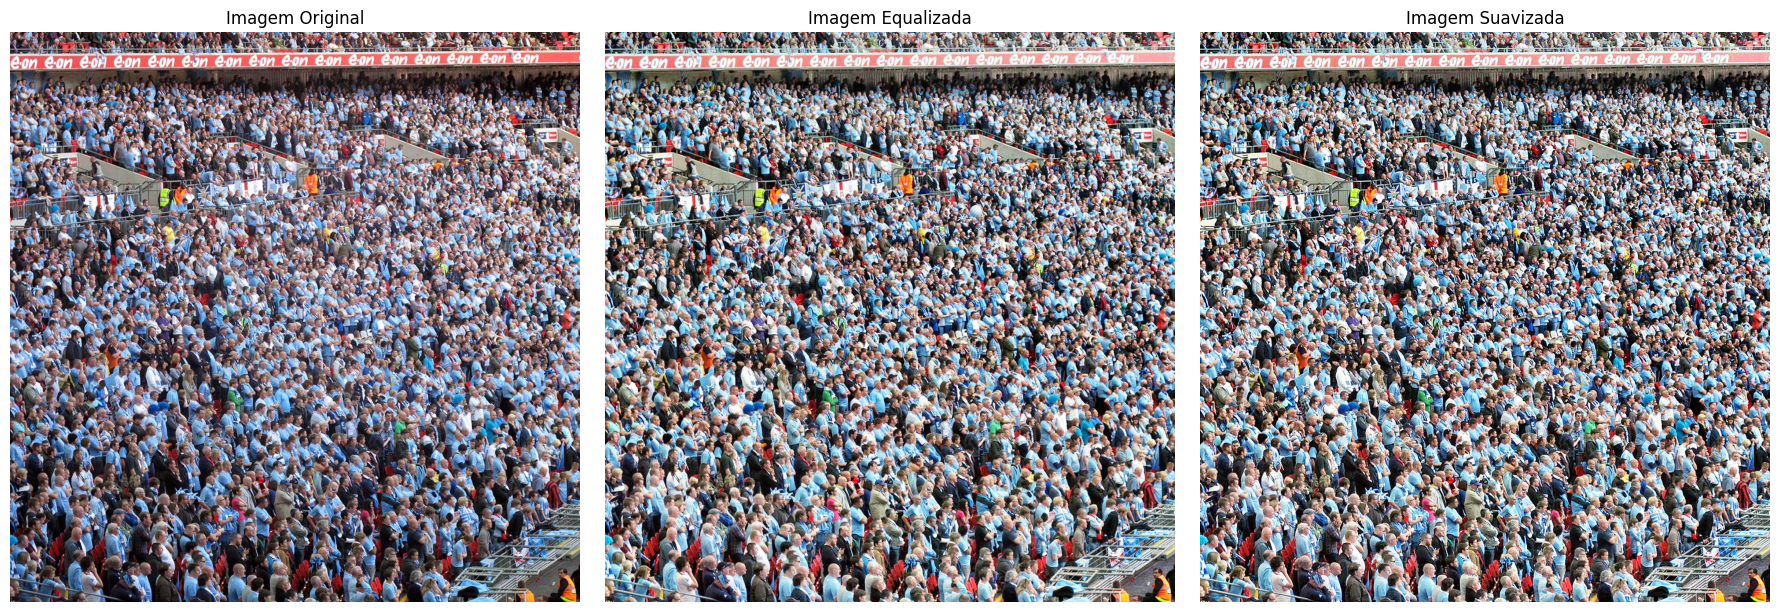

In [85]:
# Crie uma figura com dois subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas

# Exiba a imagem original no primeiro subplot
axes[0].imshow(img_colorida)
axes[0].set_title('Imagem Original')
axes[0].axis('off')  # Oculte os eixos

# Exiba a imagem equalizada no segundo subplot
axes[1].imshow(imagem_equalizada)
axes[1].set_title('Imagem Equalizada')
axes[1].axis('off')  # Oculte os eixos

# Exiba a imagem suavizada no terceiro subplot
axes[2].imshow(imagem_nitida)
axes[2].set_title('Imagem Suavizada')
axes[2].axis('off')

# Ajuste o layout e exiba o gráfico
plt.tight_layout()
plt.show()

In [42]:
images.shape

(5415, 200, 200, 3)

In [12]:
maps.shape

(5415, 200, 200)

In [13]:
img_classes.shape

(5415,)

In [14]:
sum_maps.shape

(5415,)

In [15]:
valores_unicos, contagem = np.unique(img_classes, return_counts=True)
contagens = dict(zip(valores_unicos, contagem))

In [16]:
for valor, contagem in contagens.items():
    print(f"Regressor {valor}: {contagem} Imagens de treino")

Regressor 1: 2565 Imagens de treino
Regressor 2: 2850 Imagens de treino


In [ ]:
for valor, contagem in contagens.items():
    print(f"Regressor {valor}: {contagem} Imagens de treino")

Regressor 1: 1052 Imagens de treino
Regressor 2: 1167 Imagens de treino
Regressor 3: 2212 Imagens de treino
Regressor 4: 534 Imagens de treino
Regressor 5: 450 Imagens de treino


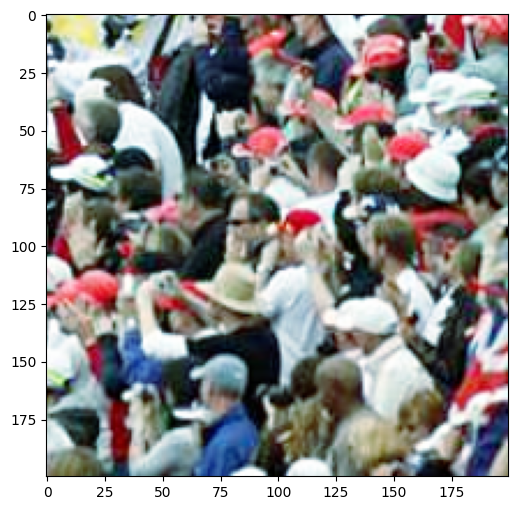

In [105]:
#Plot da Imagem:
plt.figure(figsize=(18, 6))
plt.imshow(images[600])
plt.show()

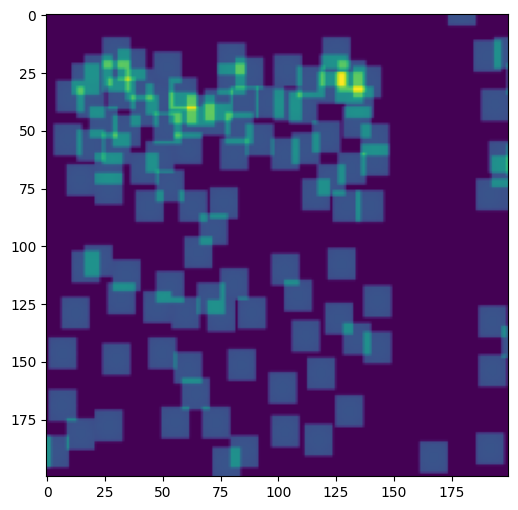

In [18]:
#Plot da Imagem:
plt.figure(figsize=(18, 6))
plt.imshow(maps[1500])
plt.show()

In [ ]:
soma_intensidades = np.sum(maps[4000])
soma_intensidades

2.944263

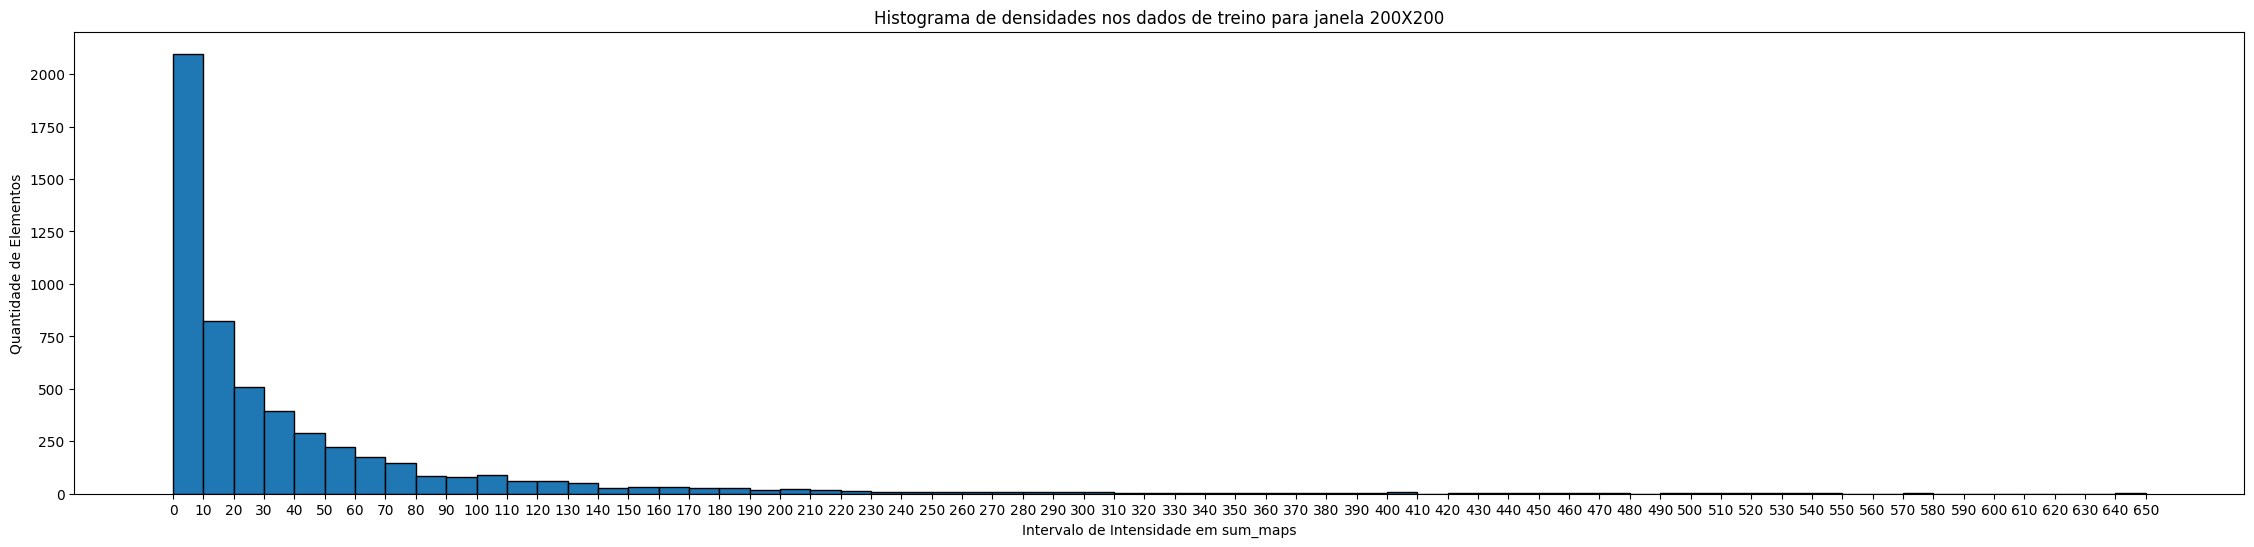

In [17]:
# Calculate the maximum value in sum_maps
max_value = int(np.max(sum_maps))

# Create dynamic intervals starting from 0, increasing by 10 up to max_value
intervalos = list(range(0, max_value + 10, 10))

# Calculate the histogram
hist, bins = np.histogram(sum_maps, bins=intervalos)

# Create the histogram plot
plt.figure(figsize=(28, 6))
plt.hist(sum_maps, bins=intervalos, edgecolor='black')
plt.xlabel('Intervalo de Intensidade em sum_maps')
plt.ylabel('Quantidade de Elementos')
plt.title('Histograma de densidades nos dados de treino para janela 200X200')

# Set x-axis ticks to the dynamic intervals
plt.xticks(intervalos)

plt.show()

# Montar o Switch

In [ ]:
from tensorflow.keras.callbacks import History

In [ ]:
switch = Sequential()
switch.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200,200,3)))
switch.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
switch.add(MaxPooling2D((2, 2)))

switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
switch.add(MaxPooling2D((2, 2)))

switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
switch.add(MaxPooling2D((2, 2)))

switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
switch.add(MaxPooling2D((2, 2)))

switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
switch.add(GlobalAveragePooling2D())

switch.add(Dense(512, activation='relu'))
switch.add(Dense(3, activation='softmax'))

switch.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
switch.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 25, 25, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 25, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 14,978,883 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img_classes = tf.keras.utils.to_categorical(img_classes-1, num_classes=3)

In [ ]:
history_callback = History()

In [ ]:
# Especificar a GPU antes de treinar o modelo
with tf.device('/GPU:0'):
    historico=switch.fit(images, img_classes, epochs=30, batch_size=32,callbacks=[history_callback])

Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 84s 441ms/step - accuracy: 0.6137 - loss: 0.8625
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 74s 422ms/step - accuracy: 0.7322 - loss: 0.6202
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 424ms/step - accuracy: 0.7674 - loss: 0.5475
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.7798 - loss: 0.5056
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.7898 - loss: 0.4729
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.8170 - loss: 0.4559
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.8049 - loss: 0.4409
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.8354 - loss: 0.3829
Epoch 9/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 420ms/step - accuracy: 0.8287 - loss: 0.3876
Epoch 10/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.8373 - loss: 0.3719
Epoch 11/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 420ms/step - accuracy: 0.8501 - loss: 0.3542
Epoch 12/30
170/170

In [ ]:
pred=switch.predict(images)

141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step


In [ ]:
mat_folder_test = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/test_data/ground-truth"
image_folder_test = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/test_data/images"
images_test,maps_test,img_classes_test,sum_maps_test=preprocesso_dataset(image_folder_test,mat_folder_test)

In [ ]:
predicoes = switch.predict(images_test)
classes_preditas = np.argmax(predicoes, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step


In [ ]:
classes_preditas

array([0, 0, 0, ..., 1, 2, 1])

In [ ]:
img_classes_test

array([0, 0, 0, ..., 2, 2, 1])

In [ ]:
acuracia = history_callback.history['accuracy']

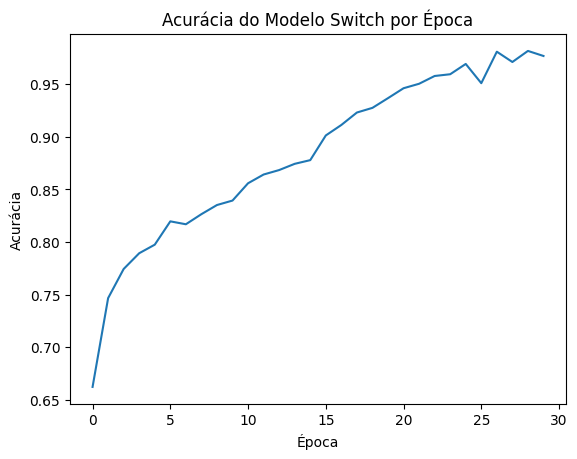

In [ ]:
plt.plot(acuracia)
plt.title('Acurácia do Modelo Switch por Época')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.show()

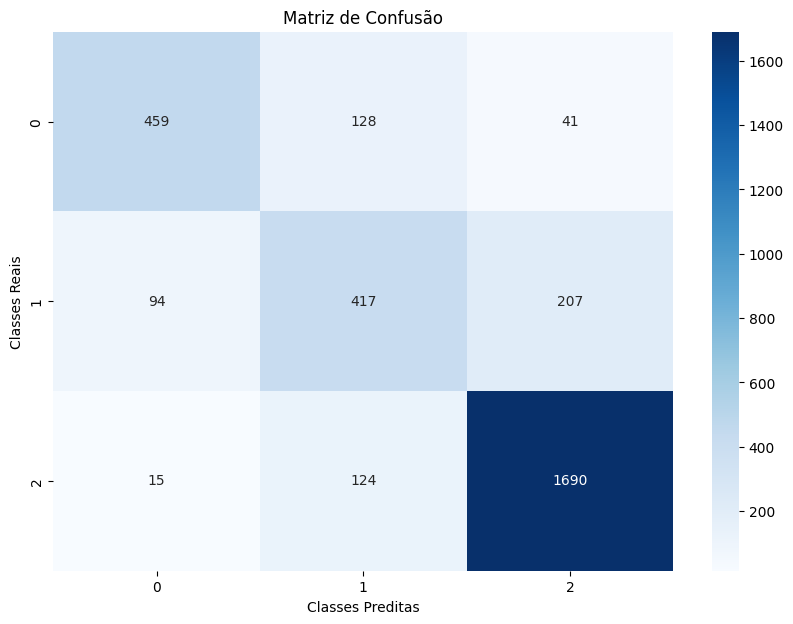

In [ ]:
matriz_confusao = confusion_matrix(img_classes_test, classes_preditas)

# Visualizar a matriz de confusão com Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Reais')
plt.title('Matriz de Confusão')
plt.show()

# Regressores

In [ ]:
def calcular_erro_medio(sum_maps_pred, sum_maps):
  """
  Calcula o erro médio das predições usando MAE, MSE e RMSE.

  Args:
      sum_maps_pred: Array NumPy contendo as predições.
      sum_maps: Array NumPy contendo os valores reais.

  Returns:
      Uma tupla contendo os valores de MAE, MSE e RMSE.
  """
  # Calcula o erro absoluto médio (MAE)
  mae = np.mean(np.abs(sum_maps_pred - sum_maps))

  # Calcula o erro quadrático médio (MSE)
  mse = np.mean((sum_maps_pred - sum_maps)**2)

  # Calcula a raiz do erro quadrático médio (RMSE)
  rmse = np.sqrt(mse)

  return mae, mse, rmse

In [ ]:
indices_r1 = np.where(img_classes == 1)[0]
images_r1 = images[indices_r1]
sum_maps_r1 = sum_maps[indices_r1]

In [ ]:
#np.savetxt('reg_1.csv', sum_maps_r1, delimiter=',')

In [ ]:
indices_r2 = np.where(img_classes == 2)[0]
images_r2 = images[indices_r2]
sum_maps_r2 = sum_maps[indices_r2]

In [ ]:
#np.savetxt('reg_2.csv', sum_maps_r2, delimiter=',')

In [ ]:
indices_r3 = np.where(img_classes == 3)[0]
images_r3 = images[indices_r3]
sum_maps_r3 = sum_maps[indices_r3]

In [ ]:
#np.savetxt('reg_3.csv', sum_maps_r3, delimiter=',')

Dados de teste

In [ ]:
mat_folder_test = "/content/drive/MyDrive/alura/ShanghaiTech/part_A/test_data/ground-truth"
image_folder_test = "/content/drive/MyDrive/alura/ShanghaiTech/part_A/test_data/images"
images_test,maps_test,img_classes_test,sum_maps_test=preprocesso_dataset(image_folder_test,mat_folder_test)

In [ ]:
indices_test_r1 = np.where(img_classes_test == 1)[0]
images_r1_test = images_test[indices_test_r1]
sum_maps_r1_test = sum_maps_test[indices_test_r1]

In [ ]:
indices_test_r2 = np.where(img_classes_test == 2)[0]
images_r2_test = images_test[indices_test_r2]
sum_maps_r2_test = sum_maps_test[indices_test_r2]

In [ ]:
indices_test_r3 = np.where(img_classes_test == 3)[0]
images_r3_test = images_test[indices_test_r3]
sum_maps_r3_test = sum_maps_test[indices_test_r3]

## Regressor 1

In [ ]:
# Criando o modelo
regressor_1 = Sequential()

# Camada Convolucional: Filtros 9x9 | 16
regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same', input_shape=(200, 200, 3)))
regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same'))
regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

# Camada Convolucional: Filtros 7x7 | 32
regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

# Camada Convolucional: Filtros 7x7 | 16
regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

# Camada Convolucional: Filtros 7x7 | 8
regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
regressor_1.add(GlobalAveragePooling2D())

# Camada Fully Connect
regressor_1.add(Flatten())
regressor_1.add(Dense(512, activation='relu'))
regressor_1.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
regressor_1.add(Dense(1, activation='linear'))

# Resumo do modelo
regressor_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_85 (Conv2D)                   │ (None, 200, 200, 16)        │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 200, 200, 16)        │          20,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 100, 100, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 100, 100, 32)        │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 100, 100, 32)        │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 100, 100, 32)        │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 50, 50, 16)          │          25,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_91 (Conv2D)                   │ (None, 50, 50, 16)          │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_92 (Conv2D)                   │ (None, 50, 50, 16)          │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 25, 25, 8)           │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 25, 25, 8)           │           3,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 25, 25, 8)           │           3,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 8)                   │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480,761 (1.83 MB)

 Trainable params: 480,761 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/GPU:0'):
    regressor_1.compile(optimizer='adam', loss='mse', metrics=['mae']) # Example using Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric
    regressor_1.fit(images_r1, sum_maps_r1, epochs=30, batch_size=16)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - loss: 1.5966 - mae: 0.6390
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.3601 - mae: 0.5111
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.3937 - mae: 0.5328
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.3524 - mae: 0.5012
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.4111 - mae: 0.5441
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.3620 - mae: 0.4901
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.3867 - mae: 0.4860
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.3695 - mae: 0.4671
Epoch 9/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.3496 - mae: 0.4414
Epoch 10/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.3776 - mae: 0.5212
Epoch 11/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.3873 - mae: 0.5370
Epoch 12/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.4002 - mae: 0.5155
Epoch 13/30
42/42 ━━━━━━━━━━━━━━━━━

Teste de erro ne predição

In [ ]:
sum_maps_pred=regressor_1.predict(images_r1_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step


In [ ]:
mae, mse, rmse = calcular_erro_medio(sum_maps_pred, sum_maps_r1_test)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.6733190417289734
MSE: 0.6721376776695251
RMSE: 0.8198400139808655


Teste de overfit

In [ ]:
sum_maps_pred=regressor_1.predict(images_r1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step


In [ ]:
mae, mse, rmse = calcular_erro_medio(sum_maps_pred, sum_maps_r1)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 0.6567884683609009
MSE: 0.6558660864830017
RMSE: 0.809855580329895


## Regressor 2

In [ ]:
# Criando o modelo
regressor_2 = Sequential()

# 1ª Camada Convolucional: Filtros 7x7 | 20
regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

# 3ª Camada Convolucional: Filtros 5x5 | 40
regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

# 5ª Camada Convolucional: Filtros 5x5 | 20
regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
regressor_2.add(Conv2D(20, (53, 5), activation='relu', padding='same'))
regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

# 6ª Camada Convolucional: Filtros 5x5 | 10
regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
regressor_2.add(GlobalAveragePooling2D())

# Camada Fully Connect
regressor_2.add(Flatten())
regressor_2.add(Dense(512, activation='relu'))
regressor_2.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
regressor_2.add(Dense(1, activation='linear'))

# Resumo do modelo
regressor_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 20)        │           2,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 20)        │          19,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 20)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 40)        │          20,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 40)        │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 40)        │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 20)          │          20,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 50, 50, 20)          │          10,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 50, 50, 20)          │         106,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 25, 25, 10)          │           5,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 25, 25, 10)          │           2,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 25, 25, 10)          │           2,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 10)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,591 (2.05 MB)

 Trainable params: 537,591 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/GPU:0'):
    regressor_2.compile(optimizer='adam', loss='mse', metrics=['mae']) # Example using Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric
    regressor_2.fit(images_r2, sum_maps_r2, epochs=30, batch_size=16)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - loss: 277.5518 - mae: 8.0459
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 9.1100 - mae: 2.5022
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 8.3936 - mae: 2.3884
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 8.3440 - mae: 2.3987
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 9.3855 - mae: 2.4809
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 8.1075 - mae: 2.3368
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 7.7571 - mae: 2.2917
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.7968 - mae: 2.2155
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.9967 - mae: 2.2617
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.9955 - mae: 2.2495
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 7.1304 - mae: 2.2414
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 6.8729 - mae: 2.2313
Epoch 13/30
54/54 ━━━━━━━━━━━━━━━

Teste de erro da prediçao

In [ ]:
sum_maps_pred=regressor_2.predict(images_r2_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step


In [ ]:
mae, mse, rmse = calcular_erro_medio(sum_maps_pred, sum_maps_r2_test)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 2.4414355754852295
MSE: 8.409795761108398
RMSE: 2.8999648094177246


Teste de overfit

In [ ]:
sum_maps_pred=regressor_2.predict(images_r2)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step


In [ ]:
mae, mse, rmse = calcular_erro_medio(sum_maps_pred, sum_maps_r2)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 2.479779005050659
MSE: 8.592308044433594
RMSE: 2.9312639236450195


## Regressor 3

In [ ]:
# Criando o modelo
regressor_3 = Sequential()

# 1ª Camada Convolucional: Filtros 5x5 | 24
regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

# 3ª Camada Convolucional: Filtros 3x3 | 48
regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

# 5ª Camada Convolucional: Filtros 3x3 | 24
regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

# 6ª Camada Convolucional: Filtros 3x3 | 12
regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
regressor_3.add(GlobalAveragePooling2D())


regressor_3.add(Flatten())
regressor_3.add(Dense(512, activation='relu'))
regressor_3.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
regressor_3.add(Dense(1, activation='linear'))

# Resumo do modelo
regressor_3.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_184 (Conv2D)                  │ (None, 200, 200, 20)        │           2,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_185 (Conv2D)                  │ (None, 200, 200, 20)        │          19,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 100, 100, 20)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_186 (Conv2D)                  │ (None, 100, 100, 40)        │          20,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_187 (Conv2D)                  │ (None, 100, 100, 40)        │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_188 (Conv2D)                  │ (None, 100, 100, 40)        │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 50, 50, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_189 (Conv2D)                  │ (None, 50, 50, 20)          │          20,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_190 (Conv2D)                  │ (None, 50, 50, 20)          │          10,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_191 (Conv2D)                  │ (None, 50, 50, 20)          │          10,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 25, 25, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_192 (Conv2D)                  │ (None, 25, 25, 10)          │           5,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_193 (Conv2D)                  │ (None, 25, 25, 10)          │           2,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_194 (Conv2D)                  │ (None, 25, 25, 10)          │           2,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 10)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 441,591 (1.68 MB)

 Trainable params: 441,591 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with tf.device('/GPU:0'):
    regressor_3.compile(optimizer='adam', loss='mse', metrics=['mae']) # Example using Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric
    regressor_3.fit(images_r3, sum_maps_r3, epochs=30, batch_size=16)

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 10744.0059 - mae: 65.7191
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 7227.8091 - mae: 51.8620
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 9239.0801 - mae: 57.9488
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 5911.2534 - mae: 50.5685
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 6509.9805 - mae: 53.6673
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 6290.5576 - mae: 52.3391
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 6002.8589 - mae: 52.2388
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 5559.6431 - mae: 50.1616
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 6131.4668 - mae: 53.0960
Epoch 10/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 6201.6943 - mae: 51.1837
Epoch 11/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 5113.3828 - mae: 48.2993
Epoch 12/30
187/187 ━━━━━━━━━━━━━━━━━━━━

Teste de erro de predição

In [ ]:
sum_maps_pred=regressor_3.predict(images_r3_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


In [ ]:
mae, mse, rmse = calcular_erro_medio(sum_maps_pred, sum_maps_r3_test)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 40.049739837646484
MSE: 3231.925537109375
RMSE: 56.85002517700195


Teste de overfit

In [ ]:
sum_maps_pred=regressor_3.predict(images_r3)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


In [ ]:
mae, mse, rmse = calcular_erro_medio(sum_maps_pred, sum_maps_r3)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 49.54965591430664
MSE: 6031.8583984375
RMSE: 77.6650390625


# Analise estatisticas dos conjuntos dos regressores

q <= 2

In [ ]:
indices_r1 = np.where(img_classes == 1)[0]
images_r1 = images[indices_r1]
sum_maps_r1 = sum_maps[indices_r1]

In [ ]:
media_1 = np.mean(sum_maps_r1)
media_1

0.37324637

In [ ]:
var_1 = np.var(sum_maps_r1)
var_1

0.3793206

In [ ]:
np.max(sum_maps_r1)

1.9979527

In [ ]:
np.min(sum_maps_r1)

0.0

2 < q <= 11

In [ ]:
indices_r2 = np.where(img_classes == 2)[0]
images_r2 = images[indices_r2]
sum_maps_r2 = sum_maps[indices_r2]

In [ ]:
media_2 = np.mean(sum_maps_r2)
media_2

6.204352

In [ ]:
var_2 = np.var(sum_maps_r2)
var_2

7.246423

In [ ]:
np.max(sum_maps_r2)

10.996197

In [ ]:
np.min(sum_maps_r2)

2.0098855

q > 11

In [ ]:
indices_r3 = np.where(img_classes == 3)[0]
images_r3 = images[indices_r3]
sum_maps_r3 = sum_maps[indices_r3]

In [ ]:
media_3 = np.mean(sum_maps_r3)
media_3

68.98081

In [ ]:
var_3 = np.var(sum_maps_r3)
var_3

6007.6543

In [ ]:
np.max(sum_maps_r3)

649.95166

In [ ]:
np.min(sum_maps_r3)

11.004934

# Switch-Cnn

## Modelo

In [ ]:
def processar_saida_switch(saida_switch):
  """Processa a saída do switch e retorna as labels das classes em um array NumPy.

  Args:
    saida_switch: A saída do switch, que é um array NumPy de probabilidades.

  Returns:
    Um array NumPy contendo as labels das classes.
  """
  # Obtém o índice da classe com maior probabilidade.
  #argmax retorna o indice do maior valor do array
  #ravel transforma uma matriz multidimensional em um array unidimensional
  labels_classes = np.argmax(saida_switch, axis=1).ravel()

  # Adiciona 1 às labels das classes, pois as classes são numeradas de 1 a 3.
  # Como argmax retorna o indice do maior valor a label seria 0,1 ou 2
  #mas como as classes estao representadas como 1,2 e 3 temos que somar 1
  labels_classes = labels_classes + 1

  return labels_classes

In [ ]:
class Switch_Cnn:
  def __init__(self, weights_path=None):
    self.switch = self.init_switch()
    self.regressor_1 = self.init_regressor_1()
    self.regressor_2 = self.init_regressor_2()
    self.regressor_3 = self.init_regressor_3()
    if weights_path:  # Load weights if path is provided
      self.load_weights(weights_path)

  def save_weights(self, weights_path):
      """Saves the weights of the switch and regressors to the specified path."""
      os.makedirs(weights_path, exist_ok=True)  # Create directory if it doesn't exist
      self.switch.save_weights(os.path.join(weights_path, 'switch.weights.h5'))
      self.regressor_1.save_weights(os.path.join(weights_path, 'regressor_1.weights.h5'))
      self.regressor_2.save_weights(os.path.join(weights_path, 'regressor_2.weights.h5'))
      self.regressor_3.save_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))

  def load_weights(self, weights_path):
    """Loads the weights of the switch and regressors from the specified path."""
    self.switch.load_weights(os.path.join(weights_path, 'switch.weights.h5'))
    self.regressor_1.load_weights(os.path.join(weights_path, 'regressor_1.weights.h5'))
    self.regressor_2.load_weights(os.path.join(weights_path, 'regressor_2.weights.h5'))
    self.regressor_3.load_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))

  def init_switch(self):
    switch = Sequential()
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200,200,3)))
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(GlobalAveragePooling2D())

    switch.add(Dense(512, activation='relu'))
    switch.add(Dense(3, activation='softmax'))
    switch.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return switch

  def init_regressor_1(self):
    regressor_1 = Sequential()

    # Camada Convolucional: Filtros 9x9 | 16
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 32
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 16
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 8
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_1.add(Flatten())
    regressor_1.add(Dense(512, activation='relu'))
    regressor_1.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_1.add(Dense(1, activation='linear'))

    regressor_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_1

  def init_regressor_2(self):
    # Criando o modelo
    regressor_2 = Sequential()

    # 1ª Camada Convolucional: Filtros 7x7 | 20
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 5x5 | 40
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 5x5 | 20
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (53, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 5x5 | 10
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_2.add(Flatten())
    regressor_2.add(Dense(512, activation='relu'))
    regressor_2.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_2.add(Dense(1, activation='linear'))

    regressor_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_2

  def init_regressor_3(self):
    # Criando o modelo
    regressor_3 = Sequential()

    # 1ª Camada Convolucional: Filtros 5x5 | 24
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 3x3 | 48
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 3x3 | 24
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 3x3 | 12
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(GlobalAveragePooling2D())


    regressor_3.add(Flatten())
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(1, activation='linear'))

    regressor_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_3

  def fit(self, image_folder, mat_folder):
    # Preprocessamento dos dados
    images,maps,img_classes,sum_maps=preprocesso_dataset(image_folder,mat_folder)

    # Conjuntos de dados de treino dos regressores
    indices_r1 = np.where(img_classes == 1)[0]
    images_r1 = images[indices_r1]
    sum_maps_r1 = sum_maps[indices_r1]

    indices_r2 = np.where(img_classes == 2)[0]
    images_r2 = images[indices_r2]
    sum_maps_r2 = sum_maps[indices_r2]

    indices_r3 = np.where(img_classes == 3)[0]
    images_r3 = images[indices_r3]
    sum_maps_r3 = sum_maps[indices_r3]

    # Treino Switch
    img_classes = tf.keras.utils.to_categorical(img_classes-1, num_classes=3)
    with tf.device('/GPU:0'):
      print('Treinamento Switch')
      self.switch.fit(images, img_classes, epochs=30, batch_size=32)
      print('Treinamento Regressor 1')
      self.regressor_1.fit(images_r1, sum_maps_r1, epochs=30, batch_size=16)
      print('Treinamento Regressor 2')
      self.regressor_2.fit(images_r2, sum_maps_r2, epochs=30, batch_size=16)
      print('Treinamento Regressor 3')
      self.regressor_3.fit(images_r3, sum_maps_r3, epochs=30, batch_size=16)
      print('Treinamento Concluido')

  def predict(self, image_folder):
    pred=[]
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            #Corta as imagens
            img_patches,d1,d2=image_crop(image)
            img_patches=np.array(img_patches)

            #Classfica as imagens
            clas_pred=self.switch.predict(img_patches)
            clas_pred=processar_saida_switch(clas_pred)

            # Pegas as imagens que fazer parte do regressor 1
            indices_r1 = np.where(clas_pred == 1)[0]
            #print(indices_r1)
            images_r1 = img_patches[indices_r1]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r2 = np.where(clas_pred == 2)[0]
            #print(indices_r2)
            images_r2 = img_patches[indices_r2]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r3 = np.where(clas_pred == 3)[0]
            #print(indices_r3)
            images_r3 = img_patches[indices_r3]

            # Faz a predição do numero de pessoas em cada imagem
            people_sum_r1 = 0  # Initialize with 0
            if len(images_r1) > 0:
              people_pred_r1 = self.regressor_1.predict(images_r1)
              people_sum_r1 = np.sum(people_pred_r1)

            people_sum_r2 = 0  # Initialize with 0
            if len(images_r2) > 0:
              people_pred_r2 = self.regressor_2.predict(images_r2)
              people_sum_r2 = np.sum(people_pred_r2)

            people_sum_r3 = 0  # Initialize with 0
            if len(images_r3) > 0:
              people_pred_r3 = self.regressor_3.predict(images_r3)
              people_sum_r3 = np.sum(people_pred_r3)

            # Soma quantas pessoas cada pessoa o regressor identificou
            #people_sum_r1=np.sum(people_pred_r1)
            #people_sum_r2=np.sum(people_pred_r2)
            #people_sum_r3=np.sum(people_pred_r3)

            # Pega o total de pessoas identificada pelos regressores
            total_people=people_sum_r1+people_sum_r2+people_sum_r3
            pred.append(total_people)
    return pred








## Validação

In [ ]:
def calcular_acuracia(y_true, y_pred):
  """Calcula a acurácia das previsões, penalizando o excesso de pessoas como erro.

  Args:
    y_true: Array NumPy contendo os valores reais do número de pessoas em cada imagem.
    y_pred: Array NumPy contendo os valores previstos pelo modelo.

  Returns:
    Um array NumPy contendo a acurácia para cada imagem.
  """
  erro = np.abs(y_pred - y_true)  # Calcula o erro absoluto
  acuracia = 100 - (erro / y_true) * 100  # Calcula a acurácia

  #Para evitar divisão por zero
  acuracia = np.nan_to_num(acuracia, nan=0.0, posinf=0.0, neginf=0.0)

  return acuracia

# Exemplo de uso
y_true = np.array([10, 15, 12, 8, 20])  # Valores reais
y_pred = np.array([9, 14, 13, 7, 25])  # Valores previstos

In [ ]:
mat_folder = "/content/drive/MyDrive/data/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = "/content/drive/MyDrive/data/ShanghaiTech/part_A/train_data/images"
mat_folder_test = "/content/drive/MyDrive/data/ShanghaiTech/part_A/test_data/ground-truth"
image_folder_test = "/content/drive/MyDrive/data/ShanghaiTech/part_A/test_data/images"

In [ ]:
model=Switch_Cnn()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(image_folder,mat_folder)

Treinamento Switch
Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 126s 607ms/step - accuracy: 0.6541 - loss: 0.8358
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 423ms/step - accuracy: 0.7426 - loss: 0.6112
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - accuracy: 0.7611 - loss: 0.5589
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.7684 - loss: 0.5510
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step - accuracy: 0.7922 - loss: 0.5043
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 422ms/step - accuracy: 0.7858 - loss: 0.4947
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.8044 - loss: 0.4612
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.8103 - loss: 0.4476
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 58s 415ms/step - accuracy: 0.8298 - loss: 0.4067
Epoch 10/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 422ms/step - accuracy: 0.8396 - loss: 0.3857
Epoch 11/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.8416 - loss: 0.3792

In [ ]:
# caso não queira retreinar
with tf.device('/GPU:0'):
  # Load model weights
  model.load_weights('/content/drive/MyDrive/data')
  # Create new Adam optimizer with desired configuration for each regressor
  adam_optimizer = Adam(learning_rate=0.001) # Example learning rate
  model.regressor_1.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_2.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_3.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

In [ ]:
pred=model.predict(image_folder_test)

# Switch-Cnn binario

## Modelo

In [12]:
def processar_saida_switch(saida_switch):
  """Processa a saída do switch e retorna as labels das classes em um array NumPy.

  Args:
    saida_switch: A saída do switch, que é um array NumPy de probabilidades.

  Returns:
    Um array NumPy contendo as labels das classes.
  """
  # Obtém o índice da classe com maior probabilidade.
  #argmax retorna o indice do maior valor do array
  #ravel transforma uma matriz multidimensional em um array unidimensional
  labels_classes = np.argmax(saida_switch, axis=1).ravel()

  # Adiciona 1 às labels das classes, pois as classes são numeradas de 1 a 3.
  # Como argmax retorna o indice do maior valor a label seria 0,1 ou 2
  #mas como as classes estao representadas como 1,2 e 3 temos que somar 1
  labels_classes = labels_classes + 1

  return labels_classes

In [21]:
class Switch_Cnn:
  def __init__(self, weights_path=None):
    self.switch = self.init_switch()
    self.regressor_1 = self.init_regressor_1()
    self.regressor_2 = self.init_regressor_2()
    self.history=None
    #self.regressor_3 = self.init_regressor_3()
    if weights_path:  # Load weights if path is provided
      self.load_weights(weights_path)

  def save_weights(self, weights_path):
      """Saves the weights of the switch and regressors to the specified path."""
      os.makedirs(weights_path, exist_ok=True)  # Create directory if it doesn't exist
      self.switch.save_weights(os.path.join(weights_path, 'switch_pre.weights.h5'))
      self.regressor_1.save_weights(os.path.join(weights_path, 'regressor_1_pre.weights.h5'))
      self.regressor_2.save_weights(os.path.join(weights_path, 'regressor_2_pre.weights.h5'))
      #self.regressor_3.save_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))

  def load_weights(self, weights_path):
    """Loads the weights of the switch and regressors from the specified path."""
    self.switch.load_weights(os.path.join(weights_path, 'switch_pre.weights.h5'))
    self.regressor_1.load_weights(os.path.join(weights_path, 'regressor_1_pre.weights.h5'))
    self.regressor_2.load_weights(os.path.join(weights_path, 'regressor_2_pre.weights.h5'))
    #self.regressor_3.load_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))

  def init_switch(self):
    switch = Sequential()
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200,200,3)))
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(GlobalAveragePooling2D())

    switch.add(Dense(512, activation='relu'))
    switch.add(Dense(2, activation='softmax'))
    switch.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return switch

  def init_regressor_1(self):
    regressor_1 = Sequential()

    # Camada Convolucional: Filtros 9x9 | 16
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 32
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 16
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 8
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_1.add(Flatten())
    regressor_1.add(Dense(512, activation='relu'))
    regressor_1.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_1.add(Dense(1, activation='linear'))

    regressor_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_1

  def init_regressor_2(self):
    # Criando o modelo
    regressor_2 = Sequential()

    # 1ª Camada Convolucional: Filtros 7x7 | 20
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 5x5 | 40
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 5x5 | 20
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (53, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 5x5 | 10
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_2.add(Flatten())
    regressor_2.add(Dense(512, activation='relu'))
    regressor_2.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_2.add(Dense(1, activation='linear'))

    regressor_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_2

  def init_regressor_3(self):
    # Criando o modelo
    regressor_3 = Sequential()

    # 1ª Camada Convolucional: Filtros 5x5 | 24
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 3x3 | 48
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 3x3 | 24
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 3x3 | 12
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(GlobalAveragePooling2D())


    regressor_3.add(Flatten())
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(1, activation='linear'))

    regressor_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_3

  def fit(self, image_folder, mat_folder):
    # Preprocessamento dos dados
    images,maps,img_classes,sum_maps=preprocesso_dataset(image_folder,mat_folder)

    # Conjuntos de dados de treino dos regressores
    indices_r1 = np.where(img_classes == 1)[0]
    images_r1 = images[indices_r1]
    sum_maps_r1 = sum_maps[indices_r1]

    indices_r2 = np.where(img_classes == 2)[0]
    images_r2 = images[indices_r2]
    sum_maps_r2 = sum_maps[indices_r2]

    #indices_r3 = np.where(img_classes == 3)[0]
    #images_r3 = images[indices_r3]
    #sum_maps_r3 = sum_maps[indices_r3]

    # Treino Switch
    img_classes = tf.keras.utils.to_categorical(img_classes-1, num_classes=2)
    history_callback = History()
    with tf.device('/GPU:0'):
      print('Treinamento Switch')
      self.history=self.switch.fit(images, img_classes, epochs=30, batch_size=32,callbacks=[history_callback])
      print('Treinamento Regressor 1')
      self.regressor_1.fit(images_r1, sum_maps_r1, epochs=30, batch_size=16)
      print('Treinamento Regressor 2')
      self.regressor_2.fit(images_r2, sum_maps_r2, epochs=30, batch_size=16)
      #print('Treinamento Regressor 3')
      #self.regressor_3.fit(images_r3, sum_maps_r3, epochs=30, batch_size=16)
      print('Treinamento Concluido')

  def predict(self, image_folder):
    pred=[]
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
            imagem_equalizada=equalizar_imagem(image)
            imagem_nitida=des_pixel(imagem_equalizada)

            #Corta as imagens
            img_patches,d1,d2=image_crop(imagem_nitida)
            img_patches=np.array(img_patches)

            #Classfica as imagens
            clas_pred=self.switch.predict(img_patches)
            clas_pred=processar_saida_switch(clas_pred)

            # Pegas as imagens que fazer parte do regressor 1
            indices_r1 = np.where(clas_pred == 1)[0]
            #print(indices_r1)
            images_r1 = img_patches[indices_r1]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r2 = np.where(clas_pred == 2)[0]
            #print(indices_r2)
            images_r2 = img_patches[indices_r2]

            # Pegas as imagens que fazer parte do regressor 1
            #indices_r3 = np.where(clas_pred == 3)[0]
            #print(indices_r3)
            #images_r3 = img_patches[indices_r3]

            # Faz a predição do numero de pessoas em cada imagem
            people_sum_r1 = 0  # Initialize with 0
            if len(images_r1) > 0:
              people_pred_r1 = self.regressor_1.predict(images_r1)
              people_sum_r1 = np.sum(people_pred_r1)

            people_sum_r2 = 0  # Initialize with 0
            if len(images_r2) > 0:
              people_pred_r2 = self.regressor_2.predict(images_r2)
              people_sum_r2 = np.sum(people_pred_r2)

            #people_sum_r3 = 0  # Initialize with 0
            #if len(images_r3) > 0:
              #people_pred_r3 = self.regressor_3.predict(images_r3)
              #people_sum_r3 = np.sum(people_pred_r3)

            # Soma quantas pessoas cada pessoa o regressor identificou
            #people_sum_r1=np.sum(people_pred_r1)
            #people_sum_r2=np.sum(people_pred_r2)
            #people_sum_r3=np.sum(people_pred_r3)

            # Pega o total de pessoas identificada pelos regressores
            total_people=people_sum_r1+people_sum_r2#+people_sum_r3
            pred.append(total_people)
    return pred








## Validação

In [14]:
def extra_dataset(image_folder, mat_folder, kernel_size=5, sigma=16):
      """
      Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

      Args:
          image_folder: Caminho para a pasta contendo as imagens.
          mat_folder: Caminho para a pasta contendo os arquivos .mat.
          target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

      Returns:
          Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
      """

      X = []  # Lista para armazenar as imagens
      Y = []  # Lista para armazenar os mapas de densidade
      class_reg=[]# Lista para armazenar as classes da imagem
      sum_int=[]

      for filename in os.listdir(image_folder):
          if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
              # Carrega a imagem
              image_path = os.path.join(image_folder, filename)
              image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

              # Carrega o arquivo .mat correspondente
              mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
              mat_path = os.path.join(mat_folder, mat_filename)
              mat_data = loadmat(mat_path)

              # Extrai as coordenadas dos pontos do arquivo .mat
              points = mat_data["image_info"][0][0][0][0][0]

              # Cria o mapa de densidade
              density_map = np.zeros(image.shape[:2], dtype=np.float32)  # Inicializa com zeros
              for point in points:
                  x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                  if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                      density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

              # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
              density_map = gaussian_filter(density_map, sigma=0.8, truncate=4.0)

              # Faz os cortes da imagem e do mapa
              imgs_crop,height_img,width_img=image_crop(image)
              maps_crop,height_map,width_map=image_crop(density_map,img_lock=False,width=width_img, height=height_img)

              #Pega a classe que pertence a imagem
              class_img=classifier_img(maps_crop)

              #Pega a classe que pertence a imagem
              sum_img=sum_map(maps_crop)

              sum_int.append(np.sum(sum_img))

              for i in range(len(imgs_crop)):
                X.append(imgs_crop[i])
                Y.append(maps_crop[i])
                class_reg.append(class_img[i])
                #sum_int.append(sum_img[i])


      # Converte as listas em arrays NumPy
      X = np.array(X)
      Y = np.array(Y)
      class_reg=np.array(class_reg)
      sum_int=np.array(sum_int)

      return X, Y, class_reg, sum_int  # Retorna as imagens e os mapas de densidade e as classes

In [15]:
def calcular_acuracia(y_true, y_pred):
  """Calcula a acurácia das previsões, penalizando o excesso de pessoas como erro.

  Args:
    y_true: Array NumPy contendo os valores reais do número de pessoas em cada imagem.
    y_pred: Array NumPy contendo os valores previstos pelo modelo.

  Returns:
    Um array NumPy contendo a acurácia para cada imagem.
  """
  erro = np.abs(y_pred - y_true)  # Calcula o erro absoluto
  acuracia = 100 - (erro / y_true) * 100  # Calcula a acurácia

  #Para evitar divisão por zero
  acuracia = np.nan_to_num(acuracia, nan=0.0, posinf=0.0, neginf=0.0)

  return acuracia

# Exemplo de uso
y_true = np.array([10, 15, 12, 8, 20])  # Valores reais
y_pred = np.array([9, 14, 13, 7, 25])  # Valores previstos

In [16]:
mat_folder = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/train_data/images"
mat_folder_test = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/test_data/ground-truth"
image_folder_test = "/content/drive/MyDrive/Data/ShanghaiTech/part_A/test_data/images"

In [22]:
model=Switch_Cnn()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.fit(image_folder,mat_folder)

Treinamento Switch
Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 437ms/step - accuracy: 0.6888 - loss: 0.6503
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 76s 419ms/step - accuracy: 0.8314 - loss: 0.3822
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 415ms/step - accuracy: 0.8588 - loss: 0.3325
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 417ms/step - accuracy: 0.8549 - loss: 0.3450
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.8797 - loss: 0.3017
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.8940 - loss: 0.2562
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.9007 - loss: 0.2526
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.8995 - loss: 0.2401
Epoch 9/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.9086 - loss: 0.2297
Epoch 10/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.9126 - loss: 0.2140
Epoch 11/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.9120 - loss: 0.2100


In [24]:
model.save_weights('/content/drive/MyDrive/data')

In [25]:
model.regressor_2.save_weights('/content/drive/MyDrive/data/regressor_2_pre.weights.h5')

In [ ]:
# caso não queira retreinar
with tf.device('/GPU:0'):
  # Load model weights
  model.load_weights('/content/drive/MyDrive/data')
  # Create new Adam optimizer with desired configuration for each regressor
  adam_optimizer = Adam(learning_rate=0.001) # Example learning rate
  model.regressor_1.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_2.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_3.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

In [27]:
pred=model.predict(image_folder_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/ste

In [28]:
np.savetxt('predbi_test_prepro.csv', pred, delimiter=',')

In [29]:
images,maps,img_classes,sum_maps=extra_dataset(image_folder_test,mat_folder_test)

In [30]:
acuracias=calcular_acuracia(sum_maps, pred)

In [31]:
np.mean(acuracias)

55.0377286144158

In [32]:
acuracias_nao_outliers = acuracias[acuracias >= -100]

In [33]:
np.mean(acuracias_nao_outliers)

62.87154479753891

In [ ]:
model.save_weights('/content/drive/MyDrive/Data')

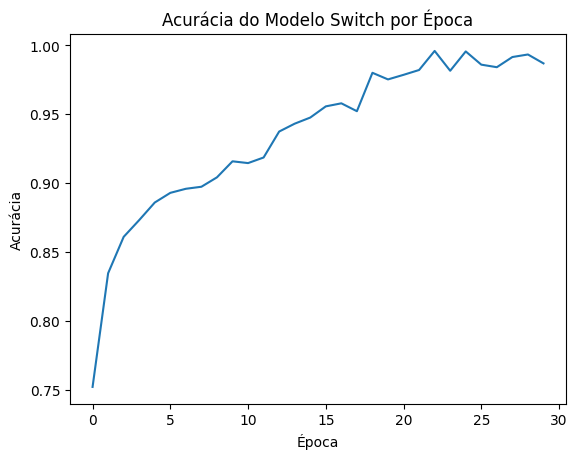

In [26]:

acuracia = model.history.history['accuracy']
plt.plot(acuracia)
plt.title('Acurácia do Modelo Switch por Época')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.show()

# Switch-Cnn 5 regressores

## Modelo

In [ ]:
def processar_saida_switch(saida_switch):
  """Processa a saída do switch e retorna as labels das classes em um array NumPy.

  Args:
    saida_switch: A saída do switch, que é um array NumPy de probabilidades.

  Returns:
    Um array NumPy contendo as labels das classes.
  """
  # Obtém o índice da classe com maior probabilidade.
  #argmax retorna o indice do maior valor do array
  #ravel transforma uma matriz multidimensional em um array unidimensional
  labels_classes = np.argmax(saida_switch, axis=1).ravel()

  # Adiciona 1 às labels das classes, pois as classes são numeradas de 1 a 3.
  # Como argmax retorna o indice do maior valor a label seria 0,1 ou 2
  #mas como as classes estao representadas como 1,2 e 3 temos que somar 1
  labels_classes = labels_classes + 1

  return labels_classes

In [ ]:
class Switch_Cnn:
  def __init__(self, weights_path=None):
    self.switch = self.init_switch()
    self.regressor_1 = self.init_regressor_1()
    self.regressor_2 = self.init_regressor_2()
    self.regressor_3 = self.init_regressor_3()
    self.regressor_4 = self.init_regressor_4()
    self.regressor_5 = self.init_regressor_5()
    self.history=None
    if weights_path:  # Load weights if path is provided
      self.load_weights(weights_path)

  def save_weights(self, weights_path):
      """Saves the weights of the switch and regressors to the specified path."""
      os.makedirs(weights_path, exist_ok=True)  # Create directory if it doesn't exist
      self.switch.save_weights(os.path.join(weights_path, 'switch.weights.h5'))
      self.regressor_1.save_weights(os.path.join(weights_path, 'regressor_1.weights.h5'))
      self.regressor_2.save_weights(os.path.join(weights_path, 'regressor_2.weights.h5'))
      self.regressor_3.save_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))
      self.regressor_4.save_weights(os.path.join(weights_path, 'regressor_4.weights.h5'))
      self.regressor_5.save_weights(os.path.join(weights_path, 'regressor_5.weights.h5'))

  def load_weights(self, weights_path):
    """Loads the weights of the switch and regressors from the specified path."""
    self.switch.load_weights(os.path.join(weights_path, 'switch.weights.h5'))
    self.regressor_1.load_weights(os.path.join(weights_path, 'regressor_1.weights.h5'))
    self.regressor_2.load_weights(os.path.join(weights_path, 'regressor_2.weights.h5'))
    self.regressor_3.load_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))
    self.regressor_4.load_weights(os.path.join(weights_path, 'regressor_4.weights.h5'))
    self.regressor_5.load_weights(os.path.join(weights_path, 'regressor_5.weights.h5'))

  def init_switch(self):
    switch = Sequential()
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200,200,3)))
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(GlobalAveragePooling2D())

    switch.add(Dense(512, activation='relu'))
    switch.add(Dense(5, activation='softmax'))
    switch.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return switch

  def init_regressor_1(self):
    regressor_1 = Sequential()

    # Camada Convolucional: Filtros 9x9 | 16
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 32
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 16
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 8
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_1.add(Flatten())
    regressor_1.add(Dense(512, activation='relu'))
    regressor_1.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_1.add(Dense(1, activation='linear'))

    regressor_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_1

  def init_regressor_2(self):
    # Criando o modelo
    regressor_2 = Sequential()

    # 1ª Camada Convolucional: Filtros 7x7 | 20
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 5x5 | 40
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 5x5 | 20
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (53, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 5x5 | 10
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_2.add(Flatten())
    regressor_2.add(Dense(512, activation='relu'))
    regressor_2.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_2.add(Dense(1, activation='linear'))

    regressor_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_2

  def init_regressor_3(self):
    # Criando o modelo
    regressor_3 = Sequential()

    # 1ª Camada Convolucional: Filtros 5x5 | 24
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 3x3 | 48
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 3x3 | 24
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 3x3 | 12
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(GlobalAveragePooling2D())


    regressor_3.add(Flatten())
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(1, activation='linear'))

    regressor_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_3

  def init_regressor_4(self):
    # Criando o modelo
    regressor_4 = Sequential()

    # 1ª Camada Convolucional: Filtros 5x5 | 24
    regressor_4.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_4.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_4.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 3x3 | 48
    regressor_4.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_4.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_4.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_4.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 3x3 | 24
    regressor_4.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_4.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_4.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_4.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 3x3 | 12
    regressor_4.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_4.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_4.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_4.add(GlobalAveragePooling2D())


    regressor_4.add(Flatten())
    regressor_4.add(Dense(512, activation='relu'))
    regressor_4.add(Dense(512, activation='relu'))
    regressor_4.add(Dense(1, activation='linear'))

    regressor_4.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_4

  def init_regressor_5(self):
    # Criando o modelo
    regressor_5 = Sequential()

    # 1ª Camada Convolucional: Filtros 5x5 | 24
    regressor_5.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 3)))
    regressor_5.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_5.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 3x3 | 48
    regressor_5.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_5.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_5.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_5.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 3x3 | 24
    regressor_5.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_5.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_5.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_5.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 3x3 | 12
    regressor_5.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_5.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_5.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_5.add(GlobalAveragePooling2D())


    regressor_5.add(Flatten())
    regressor_5.add(Dense(512, activation='relu'))
    regressor_5.add(Dense(512, activation='relu'))
    regressor_5.add(Dense(1, activation='linear'))

    regressor_5.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_5

  def fit(self, image_folder, mat_folder):
    # Preprocessamento dos dados
    images,maps,img_classes,sum_maps=preprocesso_dataset(image_folder,mat_folder)

    # Conjuntos de dados de treino dos regressores
    indices_r1 = np.where(img_classes == 1)[0]
    images_r1 = images[indices_r1]
    sum_maps_r1 = sum_maps[indices_r1]

    indices_r2 = np.where(img_classes == 2)[0]
    images_r2 = images[indices_r2]
    sum_maps_r2 = sum_maps[indices_r2]

    indices_r3 = np.where(img_classes == 3)[0]
    images_r3 = images[indices_r3]
    sum_maps_r3 = sum_maps[indices_r3]

    indices_r4 = np.where(img_classes == 4)[0]
    images_r4 = images[indices_r4]
    sum_maps_r4 = sum_maps[indices_r4]

    indices_r5 = np.where(img_classes == 5)[0]
    images_r5 = images[indices_r5]
    sum_maps_r5 = sum_maps[indices_r5]

    # Treino Switch
    img_classes = tf.keras.utils.to_categorical(img_classes-1, num_classes=5)
    history_callback = History()
    with tf.device('/GPU:0'):
      print('Treinamento Switch')
      self.history=self.switch.fit(images, img_classes, epochs=30, batch_size=32,callbacks=[history_callback])
      print('Treinamento Regressor 1')
      self.regressor_1.fit(images_r1, sum_maps_r1, epochs=30, batch_size=16)
      print('Treinamento Regressor 2')
      self.regressor_2.fit(images_r2, sum_maps_r2, epochs=30, batch_size=16)
      print('Treinamento Regressor 3')
      self.regressor_3.fit(images_r3, sum_maps_r3, epochs=30, batch_size=16)
      print('Treinamento Regressor 4')
      self.regressor_4.fit(images_r4, sum_maps_r4, epochs=30, batch_size=16)
      print('Treinamento Regressor 5')
      self.regressor_5.fit(images_r5, sum_maps_r5, epochs=60, batch_size=16)
      print('Treinamento Concluido')

  def predict(self, image_folder):
    pred=[]
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            #Corta as imagens
            img_patches,d1,d2=image_crop(image)
            img_patches=np.array(img_patches)

            #Classfica as imagens
            clas_pred=self.switch.predict(img_patches)
            clas_pred=processar_saida_switch(clas_pred)

            # Pegas as imagens que fazer parte do regressor 1
            indices_r1 = np.where(clas_pred == 1)[0]
            #print(indices_r1)
            images_r1 = img_patches[indices_r1]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r2 = np.where(clas_pred == 2)[0]
            #print(indices_r2)
            images_r2 = img_patches[indices_r2]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r3 = np.where(clas_pred == 3)[0]
            #print(indices_r3)
            images_r3 = img_patches[indices_r3]

            indices_r4 = np.where(clas_pred == 4)[0]
            #print(indices_r4)
            images_r4 = img_patches[indices_r4]

            indices_r5 = np.where(clas_pred == 5)[0]
            #print(indices_r5)
            images_r5 = img_patches[indices_r5]

            # Faz a predição do numero de pessoas em cada imagem
            people_sum_r1 = 0  # Initialize with 0
            if len(images_r1) > 0:
              people_pred_r1 = self.regressor_1.predict(images_r1)
              people_sum_r1 = np.sum(people_pred_r1)

            people_sum_r2 = 0  # Initialize with 0
            if len(images_r2) > 0:
              people_pred_r2 = self.regressor_2.predict(images_r2)
              people_sum_r2 = np.sum(people_pred_r2)

            people_sum_r3 = 0  # Initialize with 0
            if len(images_r3) > 0:
              people_pred_r3 = self.regressor_3.predict(images_r3)
              people_sum_r3 = np.sum(people_pred_r3)

            people_sum_r4 = 0  # Initialize with 0
            if len(images_r4) > 0:
              people_pred_r4 = self.regressor_4.predict(images_r4)

            people_sum_r5 = 0  # Initialize with 0
            if len(images_r5) > 0:
              people_pred_r5 = self.regressor_5.predict(images_r5)

            # Soma quantas pessoas cada pessoa o regressor identificou
            #people_sum_r1=np.sum(people_pred_r1)
            #people_sum_r2=np.sum(people_pred_r2)
            #people_sum_r3=np.sum(people_pred_r3)

            # Pega o total de pessoas identificada pelos regressores
            total_people=people_sum_r1+people_sum_r2+people_sum_r3+people_sum_r4+people_sum_r5

            # Adiciona o total de pessoas na lista de predições
            pred.append(total_people)
    return pred








## Validação

In [ ]:
def calcular_acuracia(y_true, y_pred):
  """Calcula a acurácia das previsões, penalizando o excesso de pessoas como erro.

  Args:
    y_true: Array NumPy contendo os valores reais do número de pessoas em cada imagem.
    y_pred: Array NumPy contendo os valores previstos pelo modelo.

  Returns:
    Um array NumPy contendo a acurácia para cada imagem.
  """
  erro = np.abs(y_pred - y_true)  # Calcula o erro absoluto
  acuracia = 100 - (erro / y_true) * 100  # Calcula a acurácia

  #Para evitar divisão por zero
  acuracia = np.nan_to_num(acuracia, nan=0.0, posinf=0.0, neginf=0.0)

  return acuracia

# Exemplo de uso
y_true = np.array([10, 15, 12, 8, 20])  # Valores reais
y_pred = np.array([9, 14, 13, 7, 25])  # Valores previstos

In [ ]:
def extra_dataset(image_folder, mat_folder, kernel_size=5, sigma=16):
      """
      Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

      Args:
          image_folder: Caminho para a pasta contendo as imagens.
          mat_folder: Caminho para a pasta contendo os arquivos .mat.
          target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

      Returns:
          Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
      """

      X = []  # Lista para armazenar as imagens
      Y = []  # Lista para armazenar os mapas de densidade
      class_reg=[]# Lista para armazenar as classes da imagem
      sum_int=[]

      for filename in os.listdir(image_folder):
          if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
              # Carrega a imagem
              image_path = os.path.join(image_folder, filename)
              image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

              # Carrega o arquivo .mat correspondente
              mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
              mat_path = os.path.join(mat_folder, mat_filename)
              mat_data = loadmat(mat_path)

              # Extrai as coordenadas dos pontos do arquivo .mat
              points = mat_data["image_info"][0][0][0][0][0]

              # Cria o mapa de densidade
              density_map = np.zeros(image.shape[:2], dtype=np.float32)  # Inicializa com zeros
              for point in points:
                  x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                  if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                      density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

              # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
              density_map = gaussian_filter(density_map, sigma=0.8, truncate=4.0)

              # Faz os cortes da imagem e do mapa
              imgs_crop,height_img,width_img=image_crop(image)
              maps_crop,height_map,width_map=image_crop(density_map,img_lock=False,width=width_img, height=height_img)

              #Pega a classe que pertence a imagem
              class_img=classifier_img(maps_crop)

              #Pega a classe que pertence a imagem
              sum_img=sum_map(maps_crop)

              sum_int.append(np.sum(sum_img))

              for i in range(len(imgs_crop)):
                X.append(imgs_crop[i])
                Y.append(maps_crop[i])
                class_reg.append(class_img[i])
                #sum_int.append(sum_img[i])


      # Converte as listas em arrays NumPy
      X = np.array(X)
      Y = np.array(Y)
      class_reg=np.array(class_reg)
      sum_int=np.array(sum_int)

      return X, Y, class_reg, sum_int  # Retorna as imagens e os mapas de densidade e as classes


Treino do modelo

In [ ]:
mat_folder = "/content/drive/MyDrive/data/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = "/content/drive/MyDrive/data/ShanghaiTech/part_A/train_data/images"
mat_folder_test = "/content/drive/MyDrive/data/ShanghaiTech/part_A/test_data/ground-truth"
image_folder_test = "/content/drive/MyDrive/data/ShanghaiTech/part_A/test_data/images"

In [ ]:
model=Switch_Cnn()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(image_folder,mat_folder)

Treinamento Switch
Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 117s 487ms/step - accuracy: 0.4528 - loss: 1.3657
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 101s 417ms/step - accuracy: 0.5763 - loss: 0.9946
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 418ms/step - accuracy: 0.6305 - loss: 0.8799
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.6495 - loss: 0.8275
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.6711 - loss: 0.7592
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 70s 415ms/step - accuracy: 0.6743 - loss: 0.7773
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 415ms/step - accuracy: 0.7038 - loss: 0.7039
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 419ms/step - accuracy: 0.7217 - loss: 0.6621
Epoch 9/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.7270 - loss: 0.6377
Epoch 10/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 419ms/step - accuracy: 0.7396 - loss: 0.5997
Epoch 11/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 71s 415ms/step - accuracy: 0.7713 - loss: 0.557

In [ ]:
# caso não queira retreinar
with tf.device('/GPU:0'):
  # Load model weights
  model.load_weights('/content/drive/MyDrive/data')
  # Create new Adam optimizer with desired configuration for each regressor
  adam_optimizer = Adam(learning_rate=0.001) # Example learning rate
  model.regressor_1.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_2.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_3.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Predição

In [ ]:
pred=model.predict(image_folder_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [ ]:
np.savetxt('pred_test.csv', pred, delimiter=',')

In [ ]:
pred = np.genfromtxt('/content/drive/MyDrive/data/pred_test.csv', delimiter=',')
pred.shape

(182,)

In [ ]:
model.save_weights('/content/drive/MyDrive/data')

Teste de Acuracia

In [ ]:
images,maps,img_classes,sum_maps=extra_dataset(image_folder_test,mat_folder_test)

In [ ]:
sum_maps[12]

1865.0884

In [ ]:
acuracias=calcular_acuracia(sum_maps, pred)

In [ ]:
acuracias.shape

(182,)

In [ ]:
np.mean(acuracias)

44.13229955618739

In [ ]:
acuracias_nao_outliers = acuracias[acuracias >= -100]

In [ ]:
len(acuracias_nao_outliers)

177

In [ ]:
np.mean(acuracias_nao_outliers)

46.04457527058818

In [ ]:
acuracias_nao_negativas = acuracias[acuracias >= 0]

In [ ]:
len(acuracias_nao_negativas)

168

In [ ]:
np.mean(acuracias_nao_negativas)

47.54944394362923

In [ ]:
model.load_weights('/content/drive/MyDrive/data')

In [ ]:
images,maps,img_classes,sum_maps=preprocesso_dataset(image_folder_test,mat_folder_test)

In [ ]:
images.shape

(3175, 200, 200, 3)

# Switch-Cnn Tons de Cinza

## Modelo

In [ ]:
def processar_saida_switch(saida_switch):
  """Processa a saída do switch e retorna as labels das classes em um array NumPy.

  Args:
    saida_switch: A saída do switch, que é um array NumPy de probabilidades.

  Returns:
    Um array NumPy contendo as labels das classes.
  """
  # Obtém o índice da classe com maior probabilidade.
  #argmax retorna o indice do maior valor do array
  #ravel transforma uma matriz multidimensional em um array unidimensional
  labels_classes = np.argmax(saida_switch, axis=1).ravel()

  # Adiciona 1 às labels das classes, pois as classes são numeradas de 1 a 3.
  # Como argmax retorna o indice do maior valor a label seria 0,1 ou 2
  #mas como as classes estao representadas como 1,2 e 3 temos que somar 1
  labels_classes = labels_classes + 1

  return labels_classes

In [ ]:
class Switch_Cnn:
  def __init__(self, weights_path=None):
    self.switch = self.init_switch()
    self.regressor_1 = self.init_regressor_1()
    self.regressor_2 = self.init_regressor_2()
    self.regressor_3 = self.init_regressor_3()
    if weights_path:  # Load weights if path is provided
      self.load_weights(weights_path)

  def save_weights(self, weights_path):
      """Saves the weights of the switch and regressors to the specified path."""
      os.makedirs(weights_path, exist_ok=True)  # Create directory if it doesn't exist
      self.switch.save_weights(os.path.join(weights_path, 'switch.weights.h5'))
      self.regressor_1.save_weights(os.path.join(weights_path, 'regressor_1.weights.h5'))
      self.regressor_2.save_weights(os.path.join(weights_path, 'regressor_2.weights.h5'))
      self.regressor_3.save_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))

  def load_weights(self, weights_path):
    """Loads the weights of the switch and regressors from the specified path."""
    self.switch.load_weights(os.path.join(weights_path, 'switch.weights.h5'))
    self.regressor_1.load_weights(os.path.join(weights_path, 'regressor_1.weights.h5'))
    self.regressor_2.load_weights(os.path.join(weights_path, 'regressor_2.weights.h5'))
    self.regressor_3.load_weights(os.path.join(weights_path, 'regressor_3.weights.h5'))

  def init_switch(self):
    switch = Sequential()
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 4)))
    switch.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(MaxPooling2D((2, 2)))

    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    switch.add(GlobalAveragePooling2D())

    switch.add(Dense(512, activation='relu'))
    switch.add(Dense(3, activation='softmax'))
    switch.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return switch

  def init_regressor_1(self):
    regressor_1 = Sequential()

    # Camada Convolucional: Filtros 9x9 | 16
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same', input_shape=(200, 200, 4)))
    regressor_1.add(Conv2D(16, (9, 9), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 32
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 16
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(16, (7, 7), activation='relu', padding='same'))
    regressor_1.add(MaxPooling2D(pool_size=(2, 2)))

    # Camada Convolucional: Filtros 7x7 | 8
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(Conv2D(8, (7, 7), activation='relu', padding='same'))
    regressor_1.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_1.add(Flatten())
    regressor_1.add(Dense(512, activation='relu'))
    regressor_1.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_1.add(Dense(1, activation='linear'))

    regressor_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_1

  def init_regressor_2(self):
    # Criando o modelo
    regressor_2 = Sequential()

    # 1ª Camada Convolucional: Filtros 7x7 | 20
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 4)))
    regressor_2.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 5x5 | 40
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 5x5 | 20
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(20, (53, 5), activation='relu', padding='same'))
    regressor_2.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 5x5 | 10
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_2.add(GlobalAveragePooling2D())

    # Camada Fully Connect
    regressor_2.add(Flatten())
    regressor_2.add(Dense(512, activation='relu'))
    regressor_2.add(Dense(512, activation='relu'))   # Camada totalmente conectada intermediária
    regressor_2.add(Dense(1, activation='linear'))

    regressor_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_2

  def init_regressor_3(self):
    # Criando o modelo
    regressor_3 = Sequential()

    # 1ª Camada Convolucional: Filtros 5x5 | 24
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same', input_shape=(200, 200, 4)))
    regressor_3.add(Conv2D(20, (7, 7), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ª Camada Convolucional: Filtros 3x3 | 48
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(40, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 5ª Camada Convolucional: Filtros 3x3 | 24
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(20, (5, 5), activation='relu', padding='same'))
    regressor_3.add(MaxPooling2D(pool_size=(2, 2)))

    # 6ª Camada Convolucional: Filtros 3x3 | 12
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(Conv2D(10, (5, 5), activation='relu', padding='same'))
    regressor_3.add(GlobalAveragePooling2D())


    regressor_3.add(Flatten())
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(512, activation='relu'))
    regressor_3.add(Dense(1, activation='linear'))

    regressor_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return regressor_3

  def fit(self, image_folder, mat_folder):
    # Preprocessamento dos dados
    images,maps,img_classes,sum_maps=preprocesso_dataset(image_folder,mat_folder)

    # Conjuntos de dados de treino dos regressores
    indices_r1 = np.where(img_classes == 1)[0]
    images_r1 = images[indices_r1]
    sum_maps_r1 = sum_maps[indices_r1]

    indices_r2 = np.where(img_classes == 2)[0]
    images_r2 = images[indices_r2]
    sum_maps_r2 = sum_maps[indices_r2]

    indices_r3 = np.where(img_classes == 3)[0]
    images_r3 = images[indices_r3]
    sum_maps_r3 = sum_maps[indices_r3]

    # Treino Switch
    img_classes = tf.keras.utils.to_categorical(img_classes-1, num_classes=3)
    with tf.device('/GPU:0'):
      print('Treinamento Switch')
      self.switch.fit(images, img_classes, epochs=30, batch_size=32)
      print('Treinamento Regressor 1')
      self.regressor_1.fit(images_r1, sum_maps_r1, epochs=30, batch_size=16)
      print('Treinamento Regressor 2')
      self.regressor_2.fit(images_r2, sum_maps_r2, epochs=30, batch_size=16)
      print('Treinamento Regressor 3')
      self.regressor_3.fit(images_r3, sum_maps_r3, epochs=30, batch_size=16)
      print('Treinamento Concluido')

  def predict(self, image_folder):
    pred=[]
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
            # Carrega a imagem
            image_path = os.path.join(image_folder, filename)
            image = cv2.cvtColor(cv2.imread(image_path), cv2.IMREAD_GRAYSCALE)

            #Corta as imagens
            img_patches,d1,d2=image_crop(image)
            img_patches=np.array(img_patches)

            #Classfica as imagens
            clas_pred=self.switch.predict(img_patches)
            clas_pred=processar_saida_switch(clas_pred)

            # Pegas as imagens que fazer parte do regressor 1
            indices_r1 = np.where(clas_pred == 1)[0]
            #print(indices_r1)
            images_r1 = img_patches[indices_r1]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r2 = np.where(clas_pred == 2)[0]
            #print(indices_r2)
            images_r2 = img_patches[indices_r2]

            # Pegas as imagens que fazer parte do regressor 1
            indices_r3 = np.where(clas_pred == 3)[0]
            #print(indices_r3)
            images_r3 = img_patches[indices_r3]

            # Faz a predição do numero de pessoas em cada imagem
            people_sum_r1 = 0  # Initialize with 0
            if len(images_r1) > 0:
              people_pred_r1 = self.regressor_1.predict(images_r1)
              people_sum_r1 = np.sum(people_pred_r1)

            people_sum_r2 = 0  # Initialize with 0
            if len(images_r2) > 0:
              people_pred_r2 = self.regressor_2.predict(images_r2)
              people_sum_r2 = np.sum(people_pred_r2)

            people_sum_r3 = 0  # Initialize with 0
            if len(images_r3) > 0:
              people_pred_r3 = self.regressor_3.predict(images_r3)
              people_sum_r3 = np.sum(people_pred_r3)

            # Soma quantas pessoas cada pessoa o regressor identificou
            #people_sum_r1=np.sum(people_pred_r1)
            #people_sum_r2=np.sum(people_pred_r2)
            #people_sum_r3=np.sum(people_pred_r3)

            # Pega o total de pessoas identificada pelos regressores
            total_people=people_sum_r1+people_sum_r2+people_sum_r3
            pred.append(total_people)
    return pred








## Validação

In [ ]:
def calcular_acuracia(y_true, y_pred):
  """Calcula a acurácia das previsões, penalizando o excesso de pessoas como erro.

  Args:
    y_true: Array NumPy contendo os valores reais do número de pessoas em cada imagem.
    y_pred: Array NumPy contendo os valores previstos pelo modelo.

  Returns:
    Um array NumPy contendo a acurácia para cada imagem.
  """
  erro = np.abs(y_pred - y_true)  # Calcula o erro absoluto
  acuracia = 100 - (erro / y_true) * 100  # Calcula a acurácia

  #Para evitar divisão por zero
  acuracia = np.nan_to_num(acuracia, nan=0.0, posinf=0.0, neginf=0.0)

  return acuracia

# Exemplo de uso
y_true = np.array([10, 15, 12, 8, 20])  # Valores reais
y_pred = np.array([9, 14, 13, 7, 25])  # Valores previstos

In [ ]:
def extra_dataset(image_folder, mat_folder, kernel_size=5, sigma=16):
      """
      Cria um conjunto de dados de mapas de densidade a partir de imagens e arquivos .mat.

      Args:
          image_folder: Caminho para a pasta contendo as imagens.
          mat_folder: Caminho para a pasta contendo os arquivos .mat.
          target_size: Tamanho alvo para redimensionar as imagens e os mapas de densidade.

      Returns:
          Uma tupla contendo as imagens (X) e os mapas de densidade (Y).
      """

      X = []  # Lista para armazenar as imagens
      Y = []  # Lista para armazenar os mapas de densidade
      class_reg=[]# Lista para armazenar as classes da imagem
      sum_int=[]

      for filename in os.listdir(image_folder):
          if filename.endswith(('.jpg', '.jpeg', '.png')):  # Verifica se é um arquivo de imagem
              # Carrega a imagem
              image_path = os.path.join(image_folder, filename)
              image = cv2.cvtColor(cv2.imread(image_path), cv2.IMREAD_GRAYSCALE)

              # Carrega o arquivo .mat correspondente
              mat_filename = "GT_" + filename.replace(os.path.splitext(filename)[1], '.mat')  # Substitui a extensão da imagem por .mat
              mat_path = os.path.join(mat_folder, mat_filename)
              mat_data = loadmat(mat_path)

              # Extrai as coordenadas dos pontos do arquivo .mat
              points = mat_data["image_info"][0][0][0][0][0]

              # Cria o mapa de densidade
              density_map = np.zeros(image.shape[:2], dtype=np.float32)  # Inicializa com zeros
              for point in points:
                  x, y = int(point[0]), int(point[1])  # Converte as coordenadas para inteiros
                  if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Verifica se as coordenadas estão dentro dos limites da imagem
                      density_map[y, x] = 1  # Define o valor como 1 nos pontos de localização das pessoas

              # Aplica a função de kernel (filtro gaussiano) para suavizar o mapa de densidade
              density_map = gaussian_filter(density_map, sigma=0.8, truncate=4.0)

              # Faz os cortes da imagem e do mapa
              imgs_crop,height_img,width_img=image_crop(image)
              maps_crop,height_map,width_map=image_crop(density_map,img_lock=False,width=width_img, height=height_img)

              #Pega a classe que pertence a imagem
              class_img=classifier_img(maps_crop)

              #Pega a classe que pertence a imagem
              sum_img=sum_map(maps_crop)

              sum_int.append(np.sum(sum_img))

              for i in range(len(imgs_crop)):
                X.append(imgs_crop[i])
                Y.append(maps_crop[i])
                class_reg.append(class_img[i])
                #sum_int.append(sum_img[i])


      # Converte as listas em arrays NumPy
      X = np.array(X)
      Y = np.array(Y)
      class_reg=np.array(class_reg)
      sum_int=np.array(sum_int)

      return X, Y, class_reg, sum_int  # Retorna as imagens e os mapas de densidade e as classes


Treino do modelo

In [ ]:
mat_folder = "/content/drive/MyDrive/pdi/ShanghaiTech/part_A/train_data/ground-truth"
image_folder = "/content/drive/MyDrive/pdi/ShanghaiTech/part_A/train_data/images"
mat_folder_test = "/content/drive/MyDrive/pdi/ShanghaiTech/part_A/test_data/ground-truth"
image_folder_test = "/content/drive/MyDrive/pdi/ShanghaiTech/part_A/test_data/images"

In [ ]:
model=Switch_Cnn()

In [ ]:
model.fit(image_folder,mat_folder)

Treinamento Switch
Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 122s 502ms/step - accuracy: 0.6190 - loss: 0.8885
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 97s 426ms/step - accuracy: 0.7367 - loss: 0.6064
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.7610 - loss: 0.5701
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 426ms/step - accuracy: 0.7795 - loss: 0.5273
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.7852 - loss: 0.5119
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 423ms/step - accuracy: 0.7924 - loss: 0.4938
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 426ms/step - accuracy: 0.8048 - loss: 0.4723
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 72s 423ms/step - accuracy: 0.8231 - loss: 0.4338
Epoch 9/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 426ms/step - accuracy: 0.8349 - loss: 0.3980
Epoch 10/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.8458 - loss: 0.3651
Epoch 11/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 426ms/step - accuracy: 0.8403 - loss: 0.3642

In [ ]:
# caso não queira retreinar
with tf.device('/GPU:0'):
  # Load model weights
  model.load_weights('/content/drive/MyDrive/pdi')
  # Create new Adam optimizer with desired configuration for each regressor
  adam_optimizer = Adam(learning_rate=0.001) # Example learning rate
  model.regressor_1.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_2.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])
  model.regressor_3.compile(optimizer=adam_optimizer, loss='mse', metrics=['mae'])

Predição

In [ ]:
pred=model.predict(image_folder_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933

In [ ]:
np.savetxt('pred_test.csv', pred, delimiter=',')

In [ ]:
pred = np.genfromtxt('/content/drive/MyDrive/data/pred_test.csv', delimiter=',')
pred.shape

(182,)

Teste de Acuracia

In [ ]:
images,maps,img_classes,sum_maps=extra_dataset(image_folder_test,mat_folder_test)

In [ ]:
sum_maps[12]

1865.0884

In [ ]:
acuracias=calcular_acuracia(sum_maps, pred)

In [ ]:
acuracias.shape

(182,)

In [ ]:
np.mean(acuracias)

46.92382689595645

In [ ]:
acuracias_nao_outliers = acuracias[acuracias >= -100]

In [ ]:
len(acuracias_nao_outliers)

177

In [ ]:
np.mean(acuracias_nao_outliers)

59.91241870413784

In [ ]:
acuracias_nao_negativas = acuracias[acuracias >= 0]

In [ ]:
len(acuracias_nao_negativas)

In [ ]:
np.mean(acuracias_nao_negativas)

67.09259990037727